In [ ]:
import subprocess

# Installation on Google Colab
try:
    import google.colab
    subprocess.run(['python', '-m', 'pip', 'install',  'transformers', 'joblib', 'calamanCy'])
except ImportError:
    pass

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch

MODELS_FOLDER = '/content/drive/MyDrive/School/Thesis - Hate Speech/Models/100-try-2'
# torch.cuda.is_available = lambda: False
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


## Bernoulli Naive Bayes

In [ ]:
import joblib
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
try:
  CountVec = joblib.load(f'{MODELS_FOLDER}/model_bayes/countvec.pkl')
except FileNotFoundError:
  print("ERROR: Model not found")

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator CountVectorizer from version 1.3.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
CountVec

CountVectorizer(binary=True, lowercase=False)

In [ ]:
CountVec.vocabulary_

{'USERNAME': 20502,
 'Palangga': 15535,
 'ka': 32210,
 'man': 35904,
 'sang': 44342,
 'mga': 36751,
 'taga': 46406,
 'Bacolod': 2311,
 'vp': 48733,
 'Let': 10756,
 'Leni': 10622,
 'Lead': 10541,
 'MonLaurista': 12862,
 'Grabeh': 6955,
 'ang': 22554,
 'loilo': 34438,
 'namon': 38534,
 'Kiko': 9742,
 'Robredo': 17387,
 'iloilo': 30940,
 'kakampinkLaban': 32505,
 'Who': 21275,
 'dafuq': 26253,
 'is': 31703,
 'Jose': 8908,
 'Montemayor': 12881,
 'Jr': 8933,
 'Di': 5045,
 'na': 37317,
 'nakakatuwa': 38224,
 'yung': 49644,
 'mukha': 37204,
 'ni': 39296,
 'Mar': 12232,
 'Roxas': 17522,
 'sa': 44084,
 'TV': 19569,
 'Nakakatamad': 13765,
 'manood': 36086,
 'national': 38951,
 'elections': 27676,
 'via': 48554,
 'Binay': 2732,
 'will': 49116,
 'be': 23672,
 'staring': 45721,
 'in': 31049,
 'movie': 37168,
 'called': 24856,
 'The': 19905,
 'Dark': 4795,
 'Force': 6339,
 'Awakens': 1775,
 'Nog': 14189,
 'Hambog': 7567,
 'fact': 28271,
 'that': 46924,
 'we': 48925,
 'are': 22825,
 'even': 28045,
 '

In [ ]:
try:
  BayesModel = joblib.load(f'{MODELS_FOLDER}/model_bayes/bayes.pkl')
except FileNotFoundError:
  print("ERROR: Model not found")

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator BernoulliNB from version 1.3.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
BayesModel

BernoulliNB()

In [ ]:
def predict_bayes(inputs: list):
  inputs_transformed = CountVec.transform(inputs)
  predictions = BayesModel.predict(inputs_transformed)
  return predictions

def predict_proba_bayes(inputs: list):
  inputs_transformed = CountVec.transform(inputs)
  predictions = BayesModel.predict_proba(inputs_transformed)
  return predictions

## LSTM

In [ ]:
import calamancy

Calamancy = calamancy.load("tl_calamancy_md-0.1.0")

Calamancy

/usr/local/lib/python3.10/dist-packages/spacy/util.py:918: UserWarning: [W094] Model 'tl_calamancy_md' (0.1.0) specifies an under-constrained spaCy version requirement: >=3.5.0. This can lead to compatibility problems with older versions, or as new spaCy versions are released, because the model may say it's compatible when it's not. Consider changing the "spacy_version" in your meta.json to a version range, with a lower and upper pin. For example: >=3.7.4,<3.8.0
  warnings.warn(warn_msg)


In [ ]:
import pandas as pd
import numpy as np
from torch import Tensor

def get_calamancy_tokens(data):
  # Allows it to work with both dataframes and
  # simple lists of strings
  if isinstance(data, pd.Series):
    data = data.values

  samples = []

  for sample in Calamancy.pipe(data):
    tokens = [
      token
      for token
      in sample
    ]

    samples.append(tokens)

  return samples

def get_token_vectors(tokens):
  vectors = []

  for sample in tokens:
    vector = Tensor(np.array([token.vector for token in sample]))

    vectors.append(vector)

  return vectors

def get_input_lengths(inputs):
  return [len(sample) for sample in inputs]

In [ ]:
import torch
from torch import nn

INPUT_SIZE = 200
NUM_OF_HIDDEN_NODES = 50
OUTPUT_SIZE = 2

In [ ]:
class LstmModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.lstm = nn.LSTM(
      INPUT_SIZE,
      NUM_OF_HIDDEN_NODES,
      batch_first=True,
    )
    self.linear = nn.Linear(NUM_OF_HIDDEN_NODES, OUTPUT_SIZE)

    self.lstm_output = None
    self.lstm_packed_output = None
    self.lstm_input_lengths = None
    self.lstm_last_valid_outputs = None
    self.lstm_hidden_state = None
    self.lstm_cell_state = None

  def forward(self, input):
    self.lstm_packed_output, (self.lstm_hidden_state, self.lstm_cell_state) = self.lstm(input)

    # Unpack padded sequence to get last valid output state
    # before padding
    self.lstm_output, self.lstm_input_lengths = nn.utils.rnn.pad_packed_sequence(self.lstm_packed_output, batch_first=True)
    self.lstm_last_valid_outputs = self.lstm_output[torch.arange(self.lstm_output.size(0)), self.lstm_input_lengths - 1]

    linear_output = self.linear(self.lstm_last_valid_outputs)

    return linear_output

Lstm = LstmModel()
Lstm.load_state_dict(
  torch.load(
    f"{MODELS_FOLDER}/model_lstm/lstm_state_dict.pth",
    map_location=DEVICE,
  )
)

Lstm.to(DEVICE)

LstmModel(
  (lstm): LSTM(200, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=2, bias=True)
)

In [ ]:
Lstm.state_dict()

OrderedDict([('lstm.weight_ih_l0',
              tensor([[-0.0299,  0.1702, -0.0789,  ..., -0.0876,  0.0782, -0.0295],
                      [-0.0865, -0.2574, -0.1096,  ..., -0.0537, -0.1267, -0.1884],
                      [ 0.1750,  0.0076, -0.1551,  ..., -0.2672,  0.1077,  0.1745],
                      ...,
                      [ 0.0542, -0.1413,  0.0746,  ...,  0.0926, -0.2215, -0.0346],
                      [-0.0894, -0.0629, -0.2509,  ...,  0.0662, -0.1074,  0.1109],
                      [-0.0335, -0.0938,  0.1750,  ..., -0.0449, -0.1669, -0.1992]],
                     device='cuda:0')),
             ('lstm.weight_hh_l0',
              tensor([[ 0.0409,  0.1266, -0.0090,  ..., -0.0003,  0.0947, -0.1279],
                      [ 0.0620,  0.1572, -0.0572,  ..., -0.1911,  0.1077,  0.1340],
                      [ 0.0410, -0.1172, -0.0481,  ..., -0.0174,  0.0447, -0.0930],
                      ...,
                      [ 0.0430, -0.0281,  0.0648,  ...,  0.1466,  0.0659, -0.00

In [ ]:
softmax_function = nn.Softmax(dim=1)

In [ ]:
def process_lstm(inputs: list):
  tokens = get_calamancy_tokens(inputs)
  vectors = get_token_vectors(tokens)
  sequence_lengths = get_input_lengths(tokens)
  vectors_padded = nn.utils.rnn.pad_sequence(
    vectors,
    batch_first=True,
  )
  vectors_packed = nn.utils.rnn.pack_padded_sequence(
    vectors_padded,
    sequence_lengths,
    batch_first=True,
    enforce_sorted=False,
  )
  return vectors_packed.to(DEVICE)

def predict_proba_lstm(inputs: list):
  vectors = process_lstm(inputs)
  predictions = Lstm(vectors)
  probabilities = softmax_function(predictions)

  return probabilities.cpu()

def predict_lstm(inputs: list):
  probabilities = predict_proba_lstm(inputs)
  discrete_probabilities = torch.argmax(
    probabilities,
    dim=1,
  )
  return discrete_probabilities



## mBERT

In [ ]:
BERT_MAX_LENGTH = 255
BERT_MODEL_NAME = "bert-base-multilingual-uncased"

In [ ]:
from transformers import (
  BertForSequenceClassification,
  BertTokenizer
)

In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained(
  BERT_MODEL_NAME
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
Bert = torch.load(
  f'{MODELS_FOLDER}/model_bert/bert_state_dict.pth',
  map_location=DEVICE,
)

Bert.to(DEVICE)

Bert

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [ ]:
def process_bert(inputs):
    input_ids = []
    attention_masks = []

    for text in inputs:
        # Tokenize the text
        tokens = bert_tokenizer.tokenize(text)

        # Truncate the tokens if necessary
        if len(tokens) > BERT_MAX_LENGTH - 2:
            tokens = tokens[:BERT_MAX_LENGTH - 2]

        # Add special tokens
        tokens = ['[CLS]'] + tokens + ['[SEP]']

        # Convert tokens to token IDs
        token_ids = bert_tokenizer.convert_tokens_to_ids(tokens)

        # Pad the token IDs to BERT_MAX_LENGTH
        padding = [0] * (BERT_MAX_LENGTH - len(token_ids))
        token_ids += padding

        # Create attention mask
        attention_mask = [1] * len(tokens) + [0] * len(padding)

        input_ids.append(token_ids)
        attention_masks.append(attention_mask)

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids).to(DEVICE)
    attention_masks = torch.tensor(attention_masks).to(DEVICE)

    return input_ids, attention_masks

# Custom data loader
def data_loader(input_ids, attention_masks, batch_size):
    for i in range(0, len(input_ids), batch_size):
        yield input_ids[i:i+batch_size], attention_masks[i:i+batch_size]

def predict_proba_bert(inputs: list):
  with torch.inference_mode():
    input_ids, attention_masks = process_bert(inputs)

    all_predictions = []
    for batch_input_ids, batch_attention_masks in data_loader(input_ids, attention_masks, 16):
      batch_input_ids = batch_input_ids.to(DEVICE)
      batch_attention_masks = batch_attention_masks.to(DEVICE)

      predictions = Bert(
        batch_input_ids,
        attention_mask=batch_attention_masks,
      ).logits

      probabilities = softmax_function(predictions)

      all_predictions.append(probabilities)

    return torch.cat(all_predictions).cpu()

def predict_bert(inputs: list):
  probabilities = predict_proba_bert(inputs)
  discrete_probabilities = torch.argmax(
    probabilities,
    dim=1,
  )
  return discrete_probabilities

## Ensemble Methods

In [ ]:
def get_learner_predictions(inputs: list):
  bayes_pred = predict_bayes(inputs)
  lstm_pred = predict_lstm(inputs)
  bert_pred = predict_bert(inputs)

  return np.array([
    bayes_pred,
    lstm_pred,
    bert_pred,
  ])

def get_learner_predictions_proba(inputs: list):
  bayes_pred = predict_proba_bayes(inputs)
  lstm_pred = predict_proba_lstm(inputs)
  bert_pred = predict_proba_bert(inputs)

  return np.array([
    bayes_pred,
    lstm_pred.detach().numpy(),
    bert_pred.detach().numpy(),
  ])

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

logistic_regression = LogisticRegression()
logistic_regression

LogisticRegression()

## Data

In [ ]:
import numpy as np
import pandas as pd
import torch
import math

def shuffle_data_frame(data_frame):
    text = list(data_frame['text'])
    label = list(data_frame['label'])

    assert(len(text) == len(label))

    indices = list(range(len(label)))

    # Make a random number generator that will shuffle list of indices
    # It is seeded to be reproducible
    random_number_generator = np.random.default_rng(seed=0)
    random_number_generator.shuffle(indices)

    shuffled_text = []
    shuffled_labels = []

    # Iterate through the list of indices and add the original data
    # from those shuffled indices
    for index in indices:
        shuffled_text.append(text[index])
        shuffled_labels.append(label[index])

    return pd.DataFrame({
        'text': shuffled_text,
        'label': shuffled_labels,
    })


def get_train_test_split(data_frame: pd.DataFrame, test_size: float):
    """
    Makes a stratified train test split.
    This aims to preserve the distribution between classes.
    """
    if not (1 >= test_size >= 0):
        print('ERROR: test_size must be between 0 and 1')
        return

    data_frame = shuffle_data_frame(data_frame)

    data_frame_length = len(data_frame)
    train_size = 1 - test_size

    nonhate_rows = data_frame[data_frame['label'] == 0]
    nonhate_row_length = len(nonhate_rows)

    nonhate_row_train_size = math.ceil(nonhate_row_length * train_size)

    nonhate_row_train = nonhate_rows[0:nonhate_row_train_size]
    nonhate_row_test = nonhate_rows[nonhate_row_train_size:nonhate_row_length]

    assert(len(nonhate_row_train) + len(nonhate_row_test) == nonhate_row_length)

    hate_rows = data_frame[data_frame['label'] == 1]
    hate_row_length = len(hate_rows)

    hate_row_train_size = math.ceil(hate_row_length * train_size)

    hate_row_train = hate_rows[0:hate_row_train_size]
    hate_row_test = hate_rows[hate_row_train_size:hate_row_length]

    assert(len(hate_row_train) + len(hate_row_test) == hate_row_length)

    combined_train = pd.concat([nonhate_row_train, hate_row_train])
    combined_test = pd.concat([nonhate_row_test, hate_row_test])

    assert(len(combined_train) + len(combined_test) == data_frame_length)

    shuffled_train = shuffle_data_frame(combined_train)
    shuffled_test = shuffle_data_frame(combined_test)

    assert(len(shuffled_train) + len(shuffled_test) == data_frame_length)

    return (
        shuffled_train['text'],
        shuffled_test['text'],
        shuffled_train['label'],
        shuffled_test['label'],
    )

def seed_random_number_generators(seed=0):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    print("Random number generators seeded.")

def read_csv_file(filename: str) -> pd.DataFrame:
    try:
        data = pd.read_csv(filename, lineterminator='\n', usecols=range(2))
        print("CSV file read successfully!")
        return data
    except FileNotFoundError:
        print("ERROR: File not found")
        exit(1)

In [ ]:
dataset = read_csv_file('/content/drive/MyDrive/School/Thesis - Hate Speech/Data/datasetall.csv')

dataset

CSV file read successfully!


,text,label
0,Binay: Patuloy ang kahirapan dahil sa maling p...,0
1,SA GOBYERNONG TAPAT WELCOME SA BAGUO ANG LAHAT...,0
2,wait so ur telling me Let Leni Lead mo pero NY...,1
3,[USERNAME]wish this is just a nightmare that ...,0
4,doc willie ong and isko sabunutan po,0
...,...,...
28456,"Bisaya, Probinsyano/a, mostly Bisaya = katulong",1
28457,Amnesia. In my whole life wala pa ako nakasala...,1
28458,Kontrabida na ilang beses na tinalo at obvious...,1
28459,Yung antagonist laging kailangang sobrang sama...,1


In [ ]:
TEST_SIZE = 0.2

X_train, X_test, y_train, y_test = get_train_test_split(dataset, TEST_SIZE)

In [ ]:
X_train

0         [USERNAME] Palangga ka man sang mga taga Baco...
1                      Who dafuq is Jose Montemayor Jr.???
2        Di na nakakatuwa yung mukha ni Mar Roxas sa TV...
3                      national elections. | via[USERNAME]
4        Binay will be staring in a movie called "The D...
                               ...                        
22764    "Kala ko wala andito pala si Marcos."*pertaini...
22765    sie ~ [USERNAME]Marcos Magnanakaw Marcos Dikta...
22766                    If Mar is BatMarBinay is Bane-ay.
22767    to my moots im sorry in not sorry for flooding...
22768                                Uunlad tayo kay Binay
Name: text, Length: 22769, dtype: object

In [ ]:
y_train

0        0
1        0
2        1
3        0
4        1
        ..
22764    0
22765    1
22766    1
22767    1
22768    0
Name: label, Length: 22769, dtype: int64

In [ ]:
X_test

0                          Bakit trending ang Only Binay?
1       Mare @ Cebu [USERNAME][USERNAME] Marcos Never ...
2       Kahit anong gawin ko bakit di ko ma appreciate...
3       Oras na para tayo'y bumoto ng taong mag tataas...
4       VP[USERNAME]is currently in Zamboanga Sibugay ...
                              ...                        
5687      [USERNAME] Laban LeniAngat Buhay LahatLeni Kiko
5688    Nagconcede ka man Maimarwala ka prinnagdala ka...
5689    Did You Know that former Philippine secretary ...
5690           Bakit nakakairita commercial ni Mar Roxas?
5691    To Doc Willie Ong I'd like to believe you are ...
Name: text, Length: 5692, dtype: object

In [ ]:
y_test

0       0
1       1
2       1
3       0
4       0
       ..
5687    0
5688    1
5689    0
5690    1
5691    0
Name: label, Length: 5692, dtype: int64

## Training

In [ ]:
train_predictions = get_learner_predictions_proba(X_train)
train_predictions

array([[[9.99999993e-01, 7.00971732e-09],
        [4.59874362e-01, 5.40125638e-01],
        [3.32930516e-04, 9.99667069e-01],
        ...,
        [6.02764160e-02, 9.39723584e-01],
        [1.63029650e-01, 8.36970350e-01],
        [4.03064708e-01, 5.96935292e-01]],

       [[8.92643750e-01, 1.07356295e-01],
        [4.13331658e-01, 5.86668313e-01],
        [1.74131319e-01, 8.25868726e-01],
        ...,
        [6.43301129e-01, 3.56698871e-01],
        [5.15367417e-03, 9.94846344e-01],
        [7.13888526e-01, 2.86111444e-01]],

       [[9.85889912e-01, 1.41101247e-02],
        [3.12151182e-02, 9.68784928e-01],
        [3.60256918e-02, 9.63974357e-01],
        ...,
        [1.23049222e-01, 8.76950800e-01],
        [2.19592149e-03, 9.97804105e-01],
        [7.85229623e-01, 2.14770436e-01]]])

In [ ]:
train_positive_predictions = train_predictions[:, :, 1:]
train_positive_predictions

array([[[9.99999993e-01],
        [4.59874362e-01],
        [3.32930516e-04],
        ...,
        [6.02764160e-02],
        [1.63029650e-01],
        [4.03064708e-01]],

       [[8.92643750e-01],
        [4.13331658e-01],
        [1.74131319e-01],
        ...,
        [6.43301129e-01],
        [5.15367417e-03],
        [7.13888526e-01]],

       [[9.85889912e-01],
        [3.12151182e-02],
        [3.60256918e-02],
        ...,
        [1.23049222e-01],
        [2.19592149e-03],
        [7.85229623e-01]]])

In [ ]:
train_transposed_predictions = train_positive_predictions.T[0]
train_transposed_predictions

array([[9.99999993e-01, 8.92643750e-01, 9.85889912e-01],
       [4.59874362e-01, 4.13331658e-01, 3.12151182e-02],
       [3.32930516e-04, 1.74131319e-01, 3.60256918e-02],
       ...,
       [6.02764160e-02, 6.43301129e-01, 1.23049222e-01],
       [1.63029650e-01, 5.15367417e-03, 2.19592149e-03],
       [4.03064708e-01, 7.13888526e-01, 7.85229623e-01]])

In [ ]:
logistic_regression.fit(train_transposed_predictions, y_train)
print("Fitted logistic regression")

Fitted logistic regression


In [ ]:
logistic_regression

LogisticRegression()

In [ ]:
logistic_regression.coef_

array([[-2.4308728 ,  2.10088101, -7.04175227]])

In [ ]:
logistic_regression.intercept_

array([3.31425519])

In [ ]:
joblib.dump(logistic_regression, f'/content/drive/MyDrive/School/Colab/new-lr/negative-predicts/lr.pkl', compress=True)

['/content/drive/MyDrive/School/Colab/new-lr/negative-predicts/lr.pkl']

In [ ]:
joblib.dump(train_positive_predictions, f'/content/drive/MyDrive/School/Colab/new-lr/negative-predicts/predictions', compress=True)

['/content/drive/MyDrive/School/Colab/new-lr/negative-predicts/predictions']

## Results

In [ ]:
test_predictions = get_learner_predictions_proba(X_test)
test_predictions

array([[[8.65234865e-02, 9.13476513e-01],
        [9.33051590e-08, 9.99999907e-01],
        [3.98806821e-03, 9.96011932e-01],
        ...,
        [9.99991231e-01, 8.76931405e-06],
        [7.42873905e-05, 9.99925713e-01],
        [9.99999023e-01, 9.76503584e-07]],

       [[2.93145716e-01, 7.06854343e-01],
        [1.79268643e-02, 9.82073188e-01],
        [2.78609008e-01, 7.21391022e-01],
        ...,
        [2.64480144e-01, 7.35519826e-01],
        [1.60028726e-01, 8.39971244e-01],
        [8.60738873e-01, 1.39261156e-01]],

       [[8.91134739e-01, 1.08865224e-01],
        [2.17780750e-03, 9.97822165e-01],
        [3.86222243e-01, 6.13777757e-01],
        ...,
        [8.87858868e-01, 1.12141132e-01],
        [1.03478814e-02, 9.89652097e-01],
        [9.56674814e-01, 4.33251895e-02]]])

In [ ]:
test_positive_predictions = test_predictions[:, :, 1:]
test_positive_predictions

array([[[8.65234865e-02],
        [9.33051590e-08],
        [3.98806821e-03],
        ...,
        [9.99991231e-01],
        [7.42873905e-05],
        [9.99999023e-01]],

       [[2.93145716e-01],
        [1.79268643e-02],
        [2.78609008e-01],
        ...,
        [2.64480144e-01],
        [1.60028726e-01],
        [8.60738873e-01]],

       [[8.91134739e-01],
        [2.17780750e-03],
        [3.86222243e-01],
        ...,
        [8.87858868e-01],
        [1.03478814e-02],
        [9.56674814e-01]]])

In [ ]:
test_transposed_predictions = test_positive_predictions.T[0]
test_transposed_predictions

array([[8.65234865e-02, 2.93145716e-01, 8.91134739e-01],
       [9.33051590e-08, 1.79268643e-02, 2.17780750e-03],
       [3.98806821e-03, 2.78609008e-01, 3.86222243e-01],
       ...,
       [9.99991231e-01, 2.64480144e-01, 8.87858868e-01],
       [7.42873905e-05, 1.60028726e-01, 1.03478814e-02],
       [9.99999023e-01, 8.60738873e-01, 9.56674814e-01]])

In [ ]:
y_preds = logistic_regression.predict(test_transposed_predictions)

y_preds

array([0, 1, 1, ..., 0, 1, 0])

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
accuracy_score(y_test, y_preds)

0.8608573436401967

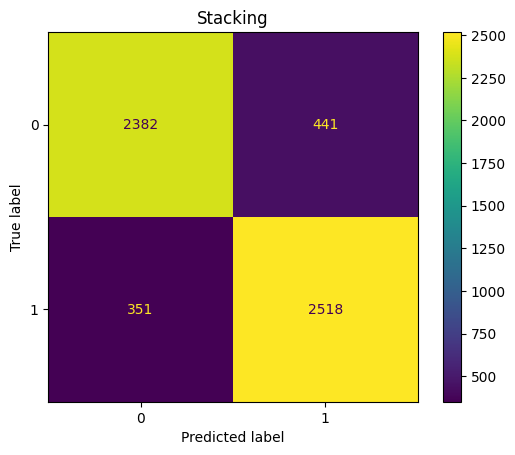

In [ ]:

stacking_conf_matrix = confusion_matrix(y_test, y_preds)

stacking_matrix_display = ConfusionMatrixDisplay(stacking_conf_matrix)

stacking_matrix_display.plot()

plt.title("Stacking")
plt.show()